In [1]:
from glob import glob
import json, datetime, time, os, random

%matplotlib inline
from matplotlib import pyplot as plt

import scipy

from scipy import ndimage, signal
import scipy.spatial.distance as distance
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import numpy as np
from numpy.lib.stride_tricks import as_strided
np.set_printoptions(precision=3, suppress=True)  # suppress scientific float notation

import pandas as pd
import os, json, platform, cvxopt
import pylab as pl
from pprint import pprint

In [28]:
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# DISTANCE METRICS
# Similarity Distance
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping Distance
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])
def DTWDistanceD(t1, t2):
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def DTWDistance2D(t1, t2):
    t1 = t1.reshape(3, 100)
    t2 = t2.reshape(3, 100)
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)
#     np.apply_along_axis(DTWDistance, 0, b)
def sample_sss(A, n):
    return A[np.random.choice(A.shape[0], n, replace=False), :]

# LOAD DATA INTO MEMORY

`
meta = {
    "L": L,
    "word_shape": word_shape,
    "description": "Accelerometer data for 2 users.",
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
`

In [3]:
DATASET_ROOT = "irb/datasets"
contents, f = get_file(DATASET_ROOT, "acc_for_2")
WORD_SHAPE = tuple(contents["word_shape"])
sss = np.array(contents["subsequences"])
user = np.array(contents["users"])
feat = np.array(contents["features"])

print(os.path.basename(f), ",".join(feat), user)
print("(n=%s, %s)" % (sss.shape))
print("word_shape --> features=%s, L=%s)" % (WORD_SHAPE))

acc_for_2.json acc-x,acc-y,acc-z [411 113]
(n=1562, 300)
word_shape --> features=3, L=100)


# GREEDY K-CENTER SAMPLING

In [4]:
def visualize_codeword(ss, ax):
    N = WORD_SHAPE[0]
    ss = ss.reshape(WORD_SHAPE)
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 0.9, N)]
    for i in range(0, N):
        ax.plot(ss[i], color=colors[i])
        
def visualize_codebook(sss, subplot=False):
    if subplot: 
        pl.rcParams['figure.figsize'] = [8, 7]
        fig, axs = pl.subplots(len(sss), 1, sharex=True)        
        for i, ss in enumerate(sss):
            visualize_codeword(ss, axs[i])
    else:
        for ss in sss:
            visualize_codeword(ss, pl)
    pl.show()


[29. 29. 29. 29. 29. 30. 25. 24. 28. 27. 27. 27. 27. 28. 26. 29. 27. 28.
 27. 28. 27. 27. 27. 27. 27. 27. 27. 28. 28. 27. 28. 28. 27. 28. 28. 28.
 28. 28. 28. 27. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 27. 26. 27. 26. 27. 28. 28. 27. 27. 28. 28.
 28. 28. 28. 28. 28. 28. 27. 28. 28. 28. 27. 26. 27. 28. 28. 28. 27. 28.
 27. 27. 29. 27. 27. 28. 27. 27. 27. 28.  2.  2.  2.  2.  2.  1.  2.  2.
  2.  2.  2.  2.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  2.  2.  2.  2.  2.
  2.  2. 55. 55. 55. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56.
 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56.
 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56. 56

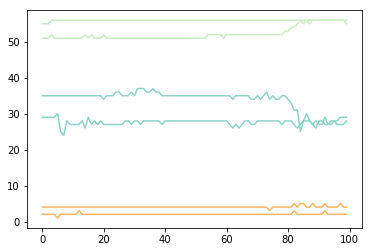

In [5]:
a = sss[0]
b = sss[10]
d2 = DTWDistance2D(a, b)
visualize_codebook([a, b], subplot=False)



In [75]:
def sample_kcenters(words, kcenters, cull_threshold=100):
    print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    n = words.shape[0]
    dist = [DTWDistance2D(kcenters[-1], words[i]) for i in range(0, n)]
    dists = np.array(dist)
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    
    return np.array(sample_kcenters(words, kcenters))

In [72]:
def sample_kcenters_pdist(words, kcenters, cull_threshold=100):
    print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    if len(words) <= 1: 
        return np.array(kcenters)
    
    dtw_along_axis = np.vectorize(DTWDistance2D, signature='(n),(m)->()')
    dists = dtw_along_axis(words, kcenters[-1])
    
    idx = np.argsort(dists)
#     print(idx)
#     print(dists)
#     print(dists[idx[0]], dists[idx[-1]])
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    return np.array(sample_kcenters(words, kcenters))
    

In [ ]:
centers = sample_kcenters_pdist(code_sample, [seed], CULL_THRESHOLD)

In [76]:
CULL_THRESHOLD = 100
SAMPLE_PROP = 0.1 # Sample X% of the subsequence dataset
SAMPLE_SIZE = int(sss.shape[0] * SAMPLE_PROP)
FIRST_CENTER = random.randint(0,SAMPLE_SIZE)
print(sss.shape, SAMPLE_SIZE)
code_sample = sample_sss(sss, SAMPLE_SIZE)
seed = code_sample[FIRST_CENTER]
code_sample = np.delete(code_sample, FIRST_CENTER, 0)

(1562, 300) 156


In [77]:
centers = sample_kcenters(code_sample, [seed], CULL_THRESHOLD)

WORDS 155 CENTERS 1
WORDS 139 CENTERS 2
WORDS 138 CENTERS 3
WORDS 136 CENTERS 4


KeyboardInterrupt: 

# HIEARCHICAL CLUSTERING

In [9]:
# generate the linkage matrix
print(centers.shape)
centers = centers.reshape(15, 300)
Z = linkage(centers, method='single', metric=DTWDistance2D)

(15, 3, 100)


In [149]:
# set cut-off to 50
max_d = 200  # max_d as in max_distance
print(centers.shape)

(66, 300)


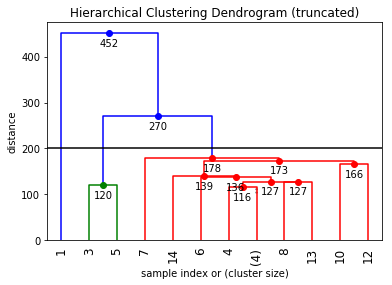

In [11]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()

# Assembling the codebook

Samples  15
Clusters found 3
2 (3, 100)
3 (3, 100)
1 (3, 100)


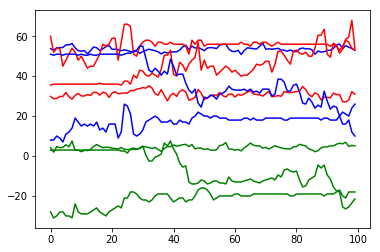

In [42]:
clusters = fcluster(Z, max_d, criterion='distance')
print("Samples ", len(centers))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)



codebook = {}
for i in range(0, len(clusters)):
    cluster_id = clusters[i]
    if not cluster_id in codebook:
        codebook[cluster_id] = []
    codebook[cluster_id].append(centers[i])
for k in codebook:
    codeset = np.array(codebook[k])
    codeset = np.average(codeset, 0)
    codebook[k] = codeset.reshape(3, 100)

for k in codebook:
    print(k, codebook[k].shape)
    
codebook = codebook.values()
visualize_codebook(codebook, subplot=False)


# Applying the codebook

In [16]:

activity = sss.reshape(1562, 300)[15:]
cb = np.array(list(codebook)).reshape(3, 300)

result = []
for i, window in enumerate(activity):
    print(i, "out of", activity.shape[0])
    codeword = np.argmin([DTWDistance2D(codeword, window) for codeword in cb])
    result.append(codeword)          

0 out of 1547
1 out of 1547
2 out of 1547
3 out of 1547
4 out of 1547
5 out of 1547
6 out of 1547
7 out of 1547
8 out of 1547
9 out of 1547
10 out of 1547
11 out of 1547
12 out of 1547
13 out of 1547
14 out of 1547
15 out of 1547
16 out of 1547
17 out of 1547
18 out of 1547
19 out of 1547
20 out of 1547
21 out of 1547
22 out of 1547
23 out of 1547
24 out of 1547
25 out of 1547
26 out of 1547
27 out of 1547
28 out of 1547
29 out of 1547
30 out of 1547
31 out of 1547
32 out of 1547
33 out of 1547
34 out of 1547
35 out of 1547
36 out of 1547
37 out of 1547
38 out of 1547
39 out of 1547
40 out of 1547
41 out of 1547
42 out of 1547
43 out of 1547
44 out of 1547
45 out of 1547
46 out of 1547
47 out of 1547
48 out of 1547
49 out of 1547
50 out of 1547
51 out of 1547
52 out of 1547
53 out of 1547
54 out of 1547
55 out of 1547
56 out of 1547
57 out of 1547
58 out of 1547
59 out of 1547
60 out of 1547
61 out of 1547
62 out of 1547
63 out of 1547
64 out of 1547
65 out of 1547
66 out of 1547
67 ou

In [33]:
arr = np.array(result)
test = np.zeros((2, 841))
test[0] = arr[0:841]
test[1] = np.pad(arr[841:], (0, 841-706), 'constant')
print(test)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


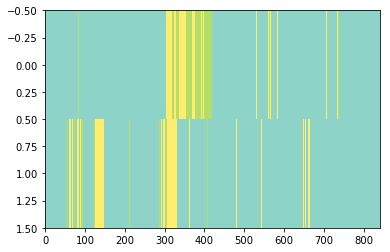

In [39]:
# pl.plot(result)
# (841, 721)
# user = users[0]


# print(arr.shape)
pl.imshow(test, cmap='Set3', interpolation='nearest', aspect='auto')
# pl.title("User %i: %s" % (user, ",".join(features)))
# pl.ylabel("Acceleration(1/64g)")
# pl.xlabel("Sample")
pl.show()

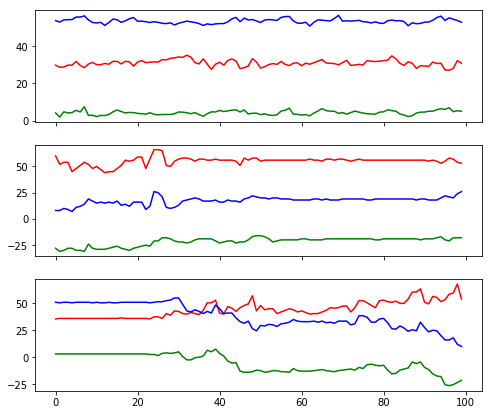

In [48]:
cb = np.array(list(codebook))
visualize_codebook(cb, subplot=True)

# Characterizing the codebook

In [129]:
n = sss.shape[0]
m = 6000/sample * n / 1000/60
print(m,'min;','n=', sample, 'out of', n)

1.562 min; n= 100 out of 1562


## K-center clustering

In [24]:
L = 16
ss = subsequences(np.array(y_gauss), L)
print("Total subsequences", len(ss))

sample_proportion = 0.02
sample_n = int(sample_proportion * len(ss))
sample_idxs = np.random.choice(ss.shape[0], sample_n, replace=False)
sample = ss[sample_idxs]
print("Total sampled n=", len(sample), sample_n/len(ss) * 100, "%")

Total subsequences 6243
Total sampled n= 124 1.9862245715201023 %


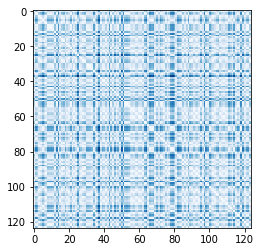

In [20]:
Y = squareform(distance.pdist(sample, DTWDistance))
plt.imshow(Y,interpolation='none',cmap='Blues')

In [22]:
# generate the linkage matrix
Z = linkage(sample, method='single', metric=DTWDistance)

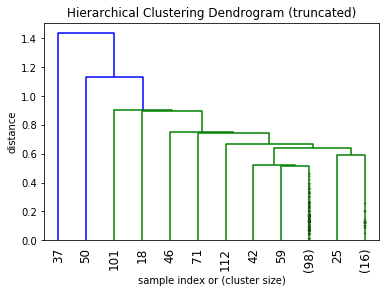

In [23]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [25]:
# set cut-off to 50
max_d = 0.4  # max_d as in max_distance

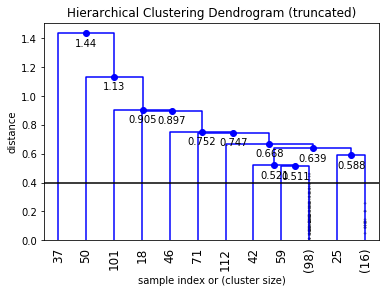

In [26]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()

In [27]:
max_d = 0.3
clusters = fcluster(Z, max_d, criterion='distance')
clusters
print("Samples ", len(sample))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)
clusters

Samples  124
Clusters found 30


array([ 8, 13, 13,  7,  4, 21,  3,  7, 13, 13, 13, 11,  3, 13, 21,  6,  7,
        3, 27, 15,  6, 13,  7,  6,  7, 23,  5,  6,  7,  3, 13, 10, 10,  6,
       21,  6, 13, 30,  7,  5,  6,  7, 20, 22, 13,  7, 26,  6, 13,  3, 29,
       21, 13, 13, 12,  6,  6,  6,  7, 19,  6,  6,  7, 13,  1,  7, 21, 21,
       21,  6, 13, 25, 13, 13,  6,  3,  6,  7, 21, 21, 21,  6,  2, 13, 14,
        7,  6,  7, 13,  3,  7,  6,  7,  7,  6, 13,  6, 21, 13, 13, 21, 28,
        7,  6, 18, 13,  7, 16,  6,  9,  7, 21, 24,  7, 21,  6, 12, 17, 21,
       13,  6, 13, 13,  7], dtype=int32)

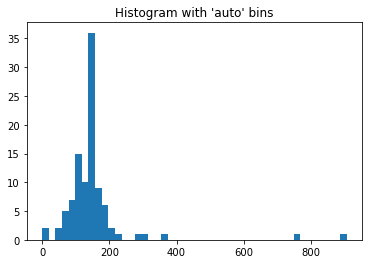

In [46]:
plt.hist(centers, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()